In [1]:
%matplotlib notebook

import numpy              as np
import matplotlib.pyplot  as plt
from scipy.interpolate    import interp1d
from scipy                import integrate
from scipy                import signal
from astropy.io           import fits
from scipy                import stats
from scipy                import optimize

<IPython.core.display.Javascript object>


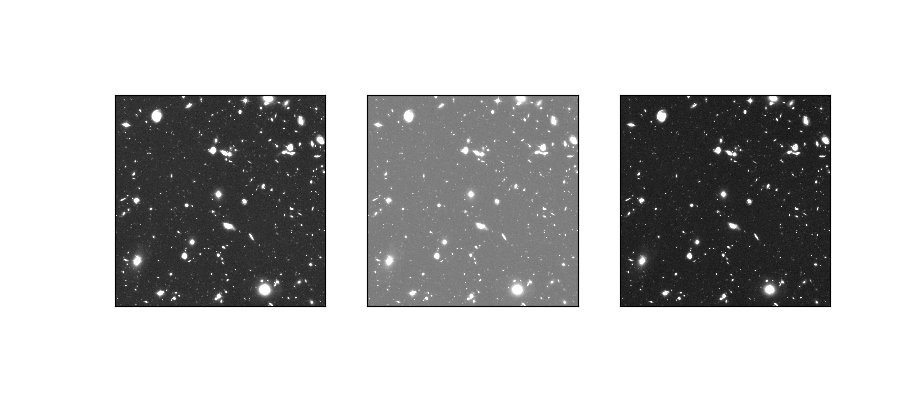

([], <a list of 0 Text xticklabel objects>)

In [5]:
nbins_min = 1500

noise_160 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/Reion/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f160w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]
noise_140 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/Reion/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f140w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]
noise_125 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/Reion/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f125w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]

plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(noise_160[::-1,:],interpolation='nearest',vmax=np.max(noise_160)/99.5/5,cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,2)
plt.imshow(noise_140[::-1,:],interpolation='nearest',vmax=np.max(noise_140)/99.5/5,cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,3)
plt.imshow(noise_125[::-1,:],interpolation='nearest',vmax=np.max(noise_125)/99.5/5,cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])

In [7]:
data_array_160 = np.reshape(noise_160,(nbins_min*nbins_min,))
data_array_140 = np.reshape(noise_140,(nbins_min*nbins_min,))
data_array_125 = np.reshape(noise_125,(nbins_min*nbins_min,))

pdf_160 = stats.gaussian_kde(data_array_160)
pdf_140 = stats.gaussian_kde(data_array_140) 
pdf_125 = stats.gaussian_kde(data_array_125) 

grid_points_x_160 = np.concatenate([np.linspace(np.min(data_array_160),0.03,1000),np.linspace(0.03,1,1000)[1:]])
grid_points_x_140 = np.concatenate([np.linspace(np.min(data_array_140),0.03,1000),np.linspace(0.03,1,1000)[1:]])
grid_points_x_125 = np.concatenate([np.linspace(np.min(data_array_125),0.03,1000),np.linspace(0.03,1,1000)[1:]])

grid_points_pdf_160 = pdf_160.evaluate(grid_points_x_160)
grid_points_pdf_140 = pdf_140.evaluate(grid_points_x_140)
grid_points_pdf_125 = pdf_125.evaluate(grid_points_x_125)

grid_points_cdf_160 = np.zeros_like(grid_points_x_160)
grid_points_cdf_140 = np.zeros_like(grid_points_x_140)
grid_points_cdf_125 = np.zeros_like(grid_points_x_125)

for i in range(0,len(grid_points_x_160)):
    for j in range(1,i+1):
        grid_points_cdf_160[i] += (grid_points_x_160[j]-grid_points_x_160[j-1])*grid_points_pdf_160[j]
        grid_points_cdf_140[i] += (grid_points_x_140[j]-grid_points_x_140[j-1])*grid_points_pdf_140[j]
        grid_points_cdf_125[i] += (grid_points_x_125[j]-grid_points_x_125[j-1])*grid_points_pdf_125[j]

<IPython.core.display.Javascript object>


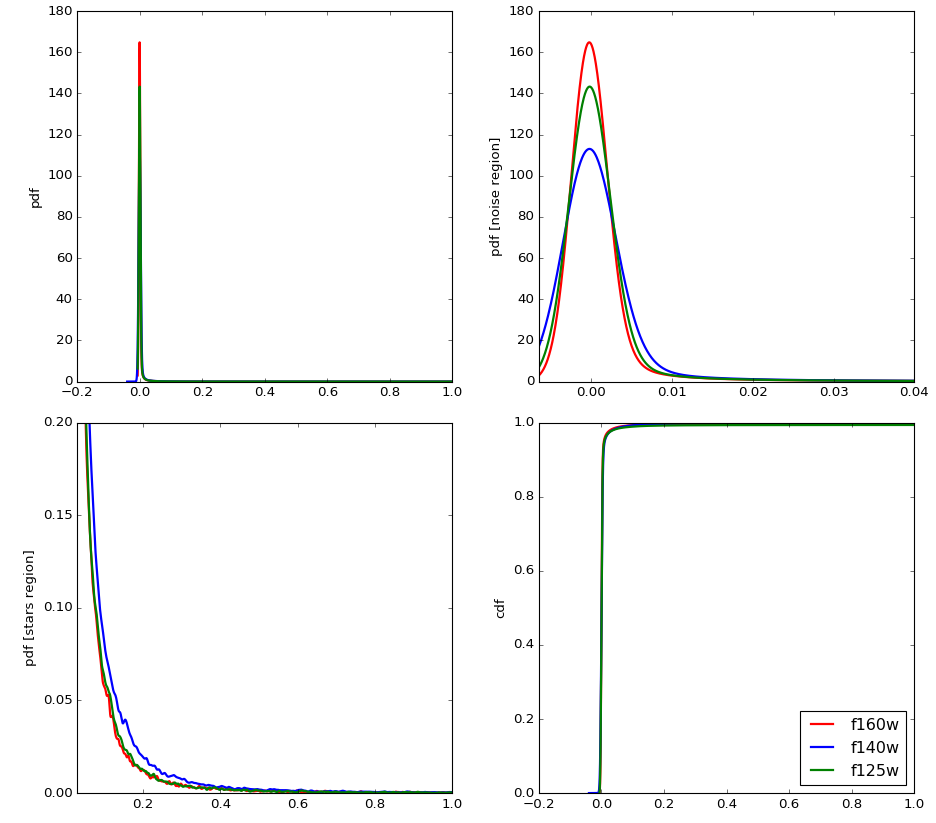

In [10]:
plt.figure(2)

plt.subplot(2,2,1)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_160,grid_points_pdf_160,c='r',lw=2.)
plt.plot(grid_points_x_140,grid_points_pdf_140,c='b',lw=2.)
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=2.)
plt.ylabel('pdf')

plt.subplot(2,2,2)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_160,grid_points_pdf_160,c='r',lw=2.)
plt.plot(grid_points_x_140,grid_points_pdf_140,c='b',lw=2.)
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=2.)
plt.xticks(np.array([0.0,0.01,0.02,0.03,0.04]))
plt.xlim(np.max(np.array([np.min(data_array_160),np.min(data_array_140),np.min(data_array_125)])),0.04)
plt.ylabel('pdf [noise region]')

plt.subplot(2,2,3)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_160,grid_points_pdf_160,c='r',lw=2.)
plt.plot(grid_points_x_140,grid_points_pdf_140,c='b',lw=2.)
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=2.)
plt.xlim(0.03,1)
plt.ylim(0,0.2)
plt.ylabel('pdf [stars region]')

plt.subplot(2,2,4)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_160,grid_points_cdf_160,c='r',lw=2.,label='f160w')
plt.plot(grid_points_x_140,grid_points_cdf_140,c='b',lw=2.,label='f140w')
plt.plot(grid_points_x_125,grid_points_cdf_125,c='g',lw=2.,label='f125w')
plt.ylabel('cdf')
plt.legend(loc='lower right')

In [12]:
def f(x,a,b):
    return stats.norm.pdf(x,a,b)

popt_160, pcov_160 = optimize.curve_fit(f,grid_points_x_160[:500],grid_points_pdf_160[:500],bounds=([-0.2,0.0], [0.2, 0.2]))
popt_140, pcov_140 = optimize.curve_fit(f,grid_points_x_140[:500],grid_points_pdf_140[:500],bounds=([-0.2,0.0], [0.2, 0.2]))
popt_125, pcov_125 = optimize.curve_fit(f,grid_points_x_125[:500],grid_points_pdf_125[:500],bounds=([-0.2,0.0], [0.2, 0.2]))

print(popt_160)
print(popt_140)
print(popt_125)

[-0.00020178  0.00239519]
[ -3.24841830e-05   3.26572605e-03]
[-0.00015609  0.00275845]


<IPython.core.display.Javascript object>


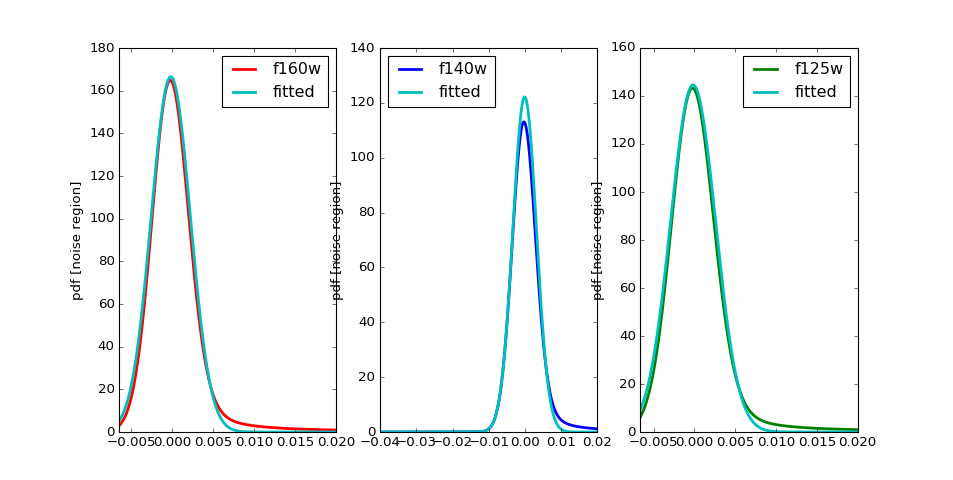

In [16]:
plt.figure(3)

plt.subplot(1,3,1)
plt.plot(grid_points_x_160,grid_points_pdf_160,c='r',lw=2.5,label='f160w')
plt.plot(grid_points_x_160,f(grid_points_x_160,popt_160[0],popt_160[1]),c='c',lw=2.5,label='fitted')
plt.xlim(np.min(data_array_160),0.02) 
plt.legend(loc='upper right')
plt.ylabel('pdf [noise region]')

plt.subplot(1,3,2)
plt.plot(grid_points_x_140,grid_points_pdf_140,c='b',lw=2.5,label='f140w')
plt.plot(grid_points_x_140,f(grid_points_x_140,popt_140[0],popt_140[1]),c='c',lw=2.5,label='fitted')
plt.xlim(np.min(data_array_140),0.02) 
plt.legend(loc='upper left')
plt.ylabel('pdf [noise region]')

plt.subplot(1,3,3)
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=2.5,label='f125w')
plt.plot(grid_points_x_125,f(grid_points_x_125,popt_125[0],popt_125[1]),c='c',lw=2.5,label='fitted')
plt.xlim(np.min(data_array_125),0.02) 
plt.legend(loc='upper right')
plt.ylabel('pdf [noise region]')

(3, 10000)
(100, 100, 3)
(101, 101, 3)
max value =  0.0072371727983
max value =  0.0143683150825
max value =  0.0112732111506

mean value =  -0.00235743453524
mean value =  0.000134244797081
mean value =  -0.00252236097313

std =  0.00300971139155
std =  0.00438082467313
std =  0.00393414843808


<IPython.core.display.Javascript object>


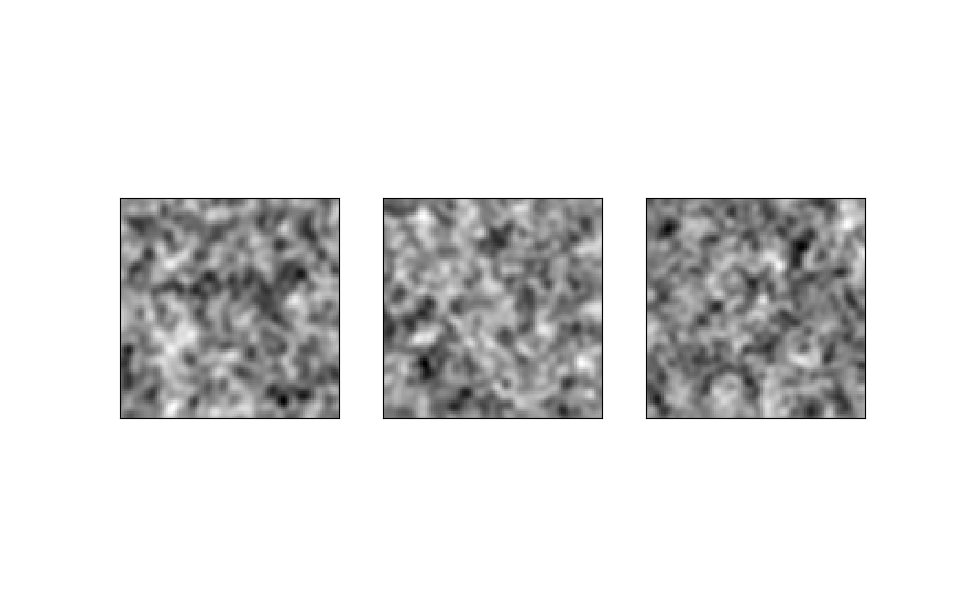

([], <a list of 0 Text xticklabel objects>)

In [23]:
nbins_min = 100

noise = np.vstack((stats.norm.rvs(popt_160[0],popt_160[1],nbins_min*nbins_min),
                   stats.norm.rvs(popt_140[0],popt_140[1],nbins_min*nbins_min),
                   stats.norm.rvs(popt_125[0],popt_125[1],nbins_min*nbins_min)))

print(np.shape(noise))

noise = np.dstack((np.reshape(noise[0,:],(nbins_min,nbins_min)),
                   np.reshape(noise[1,:],(nbins_min,nbins_min)),
                   np.reshape(noise[2,:],(nbins_min,nbins_min))))

print(np.shape(noise))

PSF = np.dstack((fits.open('PSFSTD_WFC3IR_F160W.fits')[0].data[1,:,:],
                 fits.open('PSFSTD_WFC3IR_F140W.fits')[0].data[1,:,:],
                 fits.open('PSFSTD_WFC3IR_F125W.fits')[0].data[1,:,:]))

print(np.shape(PSF))

noise_160 = signal.fftconvolve(noise[:,:,0], PSF[:,:,0], mode='same')
noise_140 = signal.fftconvolve(noise[:,:,1], PSF[:,:,1], mode='same')
noise_125 = signal.fftconvolve(noise[:,:,2], PSF[:,:,2], mode='same')

print('max value = ',np.max(noise_160))
print('max value = ',np.max(noise_140))
print('max value = ',np.max(noise_125))
print()
print('mean value = ',np.mean(noise_160))
print('mean value = ',np.mean(noise_140))
print('mean value = ',np.mean(noise_125))
print()
print('std = ',np.std(noise_160))
print('std = ',np.std(noise_140))
print('std = ',np.std(noise_125))

plt.figure(4)
plt.subplot(1,3,1)
plt.imshow(noise_160, interpolation='nearest',cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,2)
plt.imshow(noise_140, interpolation='nearest',cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])
plt.subplot(1,3,3)
plt.imshow(noise_125, interpolation='nearest',cmap=plt.cm.gray)
plt.yticks([])
plt.xticks([])